# Crime Analyzer — Classification — Modeling and Baseline Selection

Purpose
- Compare a diverse set of classifiers on the engineering-ready dataset.
- Establish robust baselines and shortlist candidates for tuning.

Inputs
- Training data: `JupyterOutputs/Classification (Preprocessing)/X_train.pkl`, `y_train.pkl`.
- Optional preprocessing artifacts: `preprocessing_pipeline_general.joblib`, `preprocessing_pipeline_trees.joblib`, `scaler_info.json`.

Outputs
- Metrics per model: `JupyterOutputs/Classification (Modeling)/model_selection_results.csv`.
- Per-model summaries: `JupyterOutputs/Classification (Modeling)/model_selection_*.json`.
- Auxiliary: `precomputed_targets.pkl`, `window_config.json` (for downstream reuse).

Key design decisions
- Cross-validation: stratified K-folds to preserve class ratios; fixed `random_state`.
- Metrics: f1, precision, recall, accuracy, mcc, roc_auc, pr_auc, neg_log_loss.
- Imbalance handling: class_weight='balanced' or re-sampling where appropriate; avoid leakage by fitting samplers within CV folds only.
- Leakage prevention: scalers/encoders fitted only on train folds; pipelines encapsulate preprocessing + model.
- Reproducibility: fixed seeds, deterministic estimators where possible, versioned artifacts under `JupyterOutputs`.


# Modeling and Windowed Target Engineering

This notebook performs model selection, windowed target engineering, and cross-validation for binary risk classification. All steps are designed to prevent data leakage and ensure robust evaluation.

## Setup and Initialization

Import all required libraries, set random seeds, and define paths for loading preprocessing artifacts and saving modeling results.

### Import Libraries

Import libraries for modeling, cross-validation, and custom transformers.

In [1]:
import os
import sys
import json
import random
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import collections
from typing import Dict, Any, List

from sklearn.model_selection import (
    StratifiedKFold, cross_validate, RandomizedSearchCV, TimeSeriesSplit
)
from sklearn.metrics import (
    log_loss, roc_auc_score, accuracy_score, f1_score, precision_score, 
    recall_score, matthews_corrcoef, make_scorer, average_precision_score
)
from sklearn.base import clone

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline

from imblearn.over_sampling import SMOTE
from imblearn.ensemble import (
    EasyEnsembleClassifier, BalancedRandomForestClassifier, BalancedBaggingClassifier
)

from Utilities.custom_transformers import STKDEAndRiskLabelTransformer, cyclical_transform, SlidingWindowSplit, CyclicalTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier, 
    BaggingClassifier, AdaBoostClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Set seeds and styles
random.seed(42)
np.random.seed(42)
sns.set_style('whitegrid')
# Warnings filter
warnings.filterwarnings('ignore')

### Define Paths and Directories

Set up directory structure for loading preprocessing results and saving modeling outputs.

In [2]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "JupyterOutputs"))

preprocessing_dir = os.path.join(base_dir, "Classification (Preprocessing)")
modeling_results_dir = os.path.join(base_dir, "Classification (Modeling)")
os.makedirs(modeling_results_dir, exist_ok=True)
print(f"Preprocessing artifacts will be loaded from: {preprocessing_dir}")
print(f"Modeling results will be saved to: {modeling_results_dir}")

Preprocessing artifacts will be loaded from: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Preprocessing)
Modeling results will be saved to: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Modeling)


### Load Preprocessing Artifacts

Load the preprocessed train/test sets, pipelines, and parameters from the preprocessing phase.

In [3]:
print("=== Loading data and pipelines ===")

def load_preprocessing_artifacts(preprocessing_dir: str) -> Dict[str, Any]:
    """Load preprocessing artifacts with comprehensive error handling.
    """
    print("=== Loading Preprocessing Artifacts ===")
    if not os.path.exists(preprocessing_dir):
        raise FileNotFoundError(f"Preprocessing directory not found: {preprocessing_dir}")
    try:
        # Load data arrays
        X_train = pd.read_pickle(os.path.join(preprocessing_dir, 'X_train.pkl'))
        X_test = pd.read_pickle(os.path.join(preprocessing_dir, 'X_test.pkl'))
        y_train = pd.read_pickle(os.path.join(preprocessing_dir, 'y_train.pkl'))
        y_test = pd.read_pickle(os.path.join(preprocessing_dir, 'y_test.pkl'))
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Required data files missing: {e}")
    except Exception as e:
        raise RuntimeError(f"Error loading data files: {e}")

    # Load preprocessors if available
    preprocessor_general_ct = None
    preprocessor_trees_ct = None
    feature_selector_general = None
    feature_selector_trees = None
    
    general_path = os.path.join(preprocessing_dir, 'preprocessing_pipeline_general.joblib')
    trees_path = os.path.join(preprocessing_dir, 'preprocessing_pipeline_trees.joblib')
    
    if os.path.exists(general_path):
        try:
            pipeline_general = joblib.load(general_path)
            preprocessor_general_ct = pipeline_general.named_steps['preprocessor'] 
            feature_selector_general = pipeline_general.named_steps.get('feature_selection', None)
        except Exception as e:
            warnings.warn(f"Failed to load general preprocessor: {e}")
    else:
        preprocessor_general_ct = None
        feature_selector_general = None

    if os.path.exists(trees_path):
        try:
            pipeline_trees = joblib.load(trees_path)
            preprocessor_trees_ct = pipeline_trees.named_steps['preprocessor'] 
            feature_selector_trees = pipeline_trees.named_steps.get('feature_selection', None)
        except Exception as e:
            warnings.warn(f"Failed to load trees preprocessor: {e}")
    else:
        preprocessor_trees_ct = None
        feature_selector_trees = None

    # Load STKDE parameters if available
    hs_optimal, ht_optimal = 200.0, 60.0
    stkde_path = os.path.join(preprocessing_dir, 'stkde_optimal_params.json')
    if os.path.exists(stkde_path):
        try:
            with open(stkde_path, 'r') as f:
                params = json.load(f)
            hs_optimal = params.get('hs_opt', hs_optimal)
            ht_optimal = params.get('ht_opt', ht_optimal)
        except Exception as e:
            warnings.warn(f"Failed to load STKDE parameters: {e}")

    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'feature_names': list(X_train.columns),
        'hs_optimal': hs_optimal,
        'ht_optimal': ht_optimal,
        'preprocessor_general_ct': preprocessor_general_ct,
        'feature_selector_general': feature_selector_general,
        'preprocessor_trees_ct': preprocessor_trees_ct,
        'feature_selector_trees': feature_selector_trees
    }

def validate_data_quality(artifacts: Dict[str, Any]) -> None:
    """Validate data quality with comprehensive checks.
    """
    print("\n=== Data Quality Validation ===")
    X_train, X_test = artifacts['X_train'], artifacts['X_test']

    if X_train.empty or X_test.empty:
        raise ValueError("Training or test data is empty")
    if not X_train.columns.equals(X_test.columns):
        raise ValueError("Training and test data have different columns")

    train_missing = X_train.isnull().sum().sum()
    test_missing = X_test.isnull().sum().sum()
    if train_missing > 0:
        print(f"Training data has {train_missing} missing values")
    if test_missing > 0:
        print(f"Test data has {test_missing} missing values")

    print(f"Data validation completed")
    print(f"  Training: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"  Test: {X_test.shape[0]} samples, {X_test.shape[1]} features")
    print(f"  Feature types: {X_train.dtypes.value_counts().to_dict()}")
    print(f"  Feature names: {', '.join(X_train.columns)}")

# Load and validate data
try:
    artifacts = load_preprocessing_artifacts(preprocessing_dir)
    validate_data_quality(artifacts)
    X_train = artifacts['X_train']
    X_test = artifacts['X_test']
    y_train = artifacts['y_train']
    y_test = artifacts['y_test']
    feature_names = artifacts['feature_names']
    hs_optimal = artifacts['hs_optimal']
    ht_optimal = artifacts['ht_optimal']
    preprocessor_general_ct = artifacts['preprocessor_general_ct']
    feature_selector_general = artifacts['feature_selector_general']
    preprocessor_trees_ct = artifacts['preprocessor_trees_ct']
    feature_selector_trees = artifacts['feature_selector_trees']

    print(f"\nX_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    print(f"Feature names: {', '.join(feature_names)}")
    print(f"hs_optimal: {hs_optimal}, ht_optimal: {ht_optimal}")

except Exception as e:
    print(f"Failed to load preprocessing artifacts: {e}")
    raise

=== Loading data and pipelines ===
=== Loading Preprocessing Artifacts ===

=== Data Quality Validation ===
Data validation completed
  Training: 570076 samples, 33 features
  Test: 144344 samples, 33 features
  Feature types: {dtype('float64'): 17, dtype('O'): 8, dtype('int64'): 8}
  Feature names: BORO_NM, LOC_OF_OCCUR_DESC, VIC_AGE_GROUP, VIC_RACE, VIC_SEX, Latitude, Longitude, BAR_DISTANCE, NIGHTCLUB_DISTANCE, ATM_DISTANCE, ATMS_COUNT, BARS_COUNT, BUS_STOPS_COUNT, METROS_COUNT, NIGHTCLUBS_COUNT, SCHOOLS_COUNT, METRO_DISTANCE, MIN_POI_DISTANCE, AVG_POI_DISTANCE, MAX_POI_DISTANCE, TOTAL_POI_COUNT, POI_DIVERSITY, POI_DENSITY_SCORE, HOUR, DAY, WEEKDAY, IS_WEEKEND, MONTH, YEAR, SEASON, TIME_BUCKET, IS_HOLIDAY, IS_PAYDAY

X_train shape: (570076, 33), X_test shape: (144344, 33)
Feature names: BORO_NM, LOC_OF_OCCUR_DESC, VIC_AGE_GROUP, VIC_RACE, VIC_SEX, Latitude, Longitude, BAR_DISTANCE, NIGHTCLUB_DISTANCE, ATM_DISTANCE, ATMS_COUNT, BARS_COUNT, BUS_STOPS_COUNT, METROS_COUNT, NIGHTCLUBS_CO

### Target Variable Selection

The target variable for classification is engineered using STKDE, creating two classes: "LOW RISK" and "HIGH RISK". This is done in a leakage-free pipeline within each CV fold.

### Update Scoring Dictionary

Update the scoring dictionary to include only metrics suitable for binary classification.

In [4]:
# Only include metrics that are informative for imbalanced binary classification
scoring = {
    # Standard classification metrics
    'f1': make_scorer(f1_score, average='binary', zero_division=0),
    'precision': make_scorer(precision_score, average='binary', zero_division=0),
    'recall': make_scorer(recall_score, average='binary', zero_division=0),
    'accuracy': make_scorer(accuracy_score),
    'mcc': make_scorer(matthews_corrcoef),

    # Probability-based metrics for imbalanced classification
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
    'pr_auc': make_scorer(average_precision_score, needs_proba=True),
    'neg_log_loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True)
}

print(f"Updated scoring dictionary for 2-class problem with {len(scoring)} metrics: {list(scoring.keys())}")

Updated scoring dictionary for 2-class problem with 8 metrics: ['f1', 'precision', 'recall', 'accuracy', 'mcc', 'roc_auc', 'pr_auc', 'neg_log_loss']


### Data Verification

Check the loaded data dimensions and class distribution of the original target variable.

In [5]:
print("=== Data verification ===")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Scoring dict keys: {list(scoring.keys())}")

print("\nClass distribution in y_train (dummy, real label will be engineered in the pipeline):")
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
print("Proportions:")
print(dict(zip(unique, counts / len(y_train))))
print("\nNote: the real target variable (2 classes) will be created in the modeling pipeline.")

def perform_data_verification(X_train: pd.DataFrame, X_test: pd.DataFrame, 
                            y_train: pd.Series, y_test: pd.Series, 
                            hs_optimal: float, ht_optimal: float) -> None:
    """
    Perform comprehensive data verification for modeling.
    """
    print("\n=== Data Verification for Modeling ===")
    print(f"Training data: {X_train.shape}")
    print(f"Test data: {X_test.shape}")
    print(f"Targets: y_train {y_train.shape}, y_test {y_test.shape}")
    print(f"STKDE parameters: hs={hs_optimal}, ht={ht_optimal}")

    # Dummy target distribution
    print("\nDummy target distribution (y_train):")
    if not y_train.empty:
        target_counts = y_train.value_counts()
        target_props = y_train.value_counts(normalize=True)
        for val in target_counts.index:
            print(f"  {val}: {target_counts[val]} ({target_props[val]:.3f})")
    else:
        print("  y_train is empty")

    print("\nNote: Real binary targets will be engineered in the modeling pipeline.")

    # Data quality checks with improved error detection
    issues = []
    train_missing = X_train.isnull().sum().sum()
    test_missing = X_test.isnull().sum().sum()
    
    if train_missing > 0:
        issues.append(f"{train_missing} missing values in training data")
    if test_missing > 0:
        issues.append(f"{test_missing} missing values in test data")
    
    object_cols = X_train.select_dtypes(include=['object']).columns
    if len(object_cols) > 0:
        issues.append(f"{len(object_cols)} columns with object dtype: {list(object_cols)}")
    
    inf_train = np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum()
    inf_test = np.isinf(X_test.select_dtypes(include=[np.number])).sum().sum()
    if inf_train > 0:
        issues.append(f"{inf_train} infinite values in training data")
    if inf_test > 0:
        issues.append(f"{inf_test} infinite values in test data")

    if issues:
        print("\nData quality issues detected:")
        for issue in issues:
            print(f"  - {issue}")
    else:
        print("\nNo major data quality issues detected.")

    # Sample preview with safe column selection
    print("\nSample data preview (first 3 rows):")
    sample_cols = X_train.columns[:min(8, len(X_train.columns))]
    print(X_train[sample_cols].head(3).to_string())
    if len(X_train.columns) > 8:
        print(f"... and {len(X_train.columns) - 8} more columns")

# Perform verification
perform_data_verification(X_train, X_test, y_train, y_test, hs_optimal, ht_optimal)

=== Data verification ===
X_train shape: (570076, 33)
y_train shape: (570076,)
X_test shape: (144344, 33)
y_test shape: (144344,)
Scoring dict keys: ['f1', 'precision', 'recall', 'accuracy', 'mcc', 'roc_auc', 'pr_auc', 'neg_log_loss']

Class distribution in y_train (dummy, real label will be engineered in the pipeline):
{0: np.int64(570076)}
Proportions:
{0: np.float64(1.0)}

Note: the real target variable (2 classes) will be created in the modeling pipeline.

=== Data Verification for Modeling ===
Training data: (570076, 33)
Test data: (144344, 33)
Targets: y_train (570076,), y_test (144344,)
STKDE parameters: hs=250, ht=75

Dummy target distribution (y_train):
  0: 570076 (1.000)

Note: Real binary targets will be engineered in the modeling pipeline.

Data quality issues detected:
  - 8 columns with object dtype: ['BORO_NM', 'LOC_OF_OCCUR_DESC', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'WEEKDAY', 'SEASON', 'TIME_BUCKET']

Sample data preview (first 3 rows):
           BORO_NM LOC_OF_O

## Model Definitions and Preprocessing Pipelines

Define the classification models to be evaluated and specify the preprocessing pipelines for each model type.

### Define Models for Comparison

Create a dictionary of model instances for binary classification.

In [6]:
def define_core_models() -> Dict[str, Any]:
    """
    Define core models for binary classification with consistent configuration.
    """
    print("\n=== Defining Core Models for Binary Classification ===")
    
    models = {
        # Baseline Models
        'Dummy': DummyClassifier(strategy='stratified', random_state=42),

        # Linear Models  
        'LogisticRegression': LogisticRegression(
            random_state=42, max_iter=1000, class_weight='balanced', 
            n_jobs=-1, solver='liblinear'
        ),

        # Distance-based Models
        'KNN': KNeighborsClassifier(n_jobs=-1, n_neighbors=5),

        # Tree-based Models
        'DecisionTree': DecisionTreeClassifier(
            random_state=42, class_weight='balanced', max_depth=10
        ),

        # Ensemble Methods - Traditional
        'RandomForest': RandomForestClassifier(
            random_state=42, class_weight='balanced', n_jobs=-1, max_depth=15
        ),
        'ExtraTrees': ExtraTreesClassifier(
            random_state=42, class_weight='balanced', n_jobs=-1, max_depth=15
        ),
        'Bagging': BaggingClassifier(random_state=42, n_jobs=-1),
        'AdaBoost': AdaBoostClassifier(
            random_state=42, learning_rate=1.0, n_estimators=50
        ),

        # Support Vector Machines
        'SVC_linear': LinearSVC(
            C=1.0, penalty='l2', loss='squared_hinge', max_iter=3000, 
            class_weight='balanced', random_state=42
        ),

        # Ensemble Methods - Imbalanced Learning
        'EasyEnsemble': EasyEnsembleClassifier(
            random_state=42, n_jobs=-1, sampling_strategy='auto'
        ),
        'BalancedRandomForest': BalancedRandomForestClassifier(
            random_state=42, n_jobs=-1, max_depth=15, sampling_strategy='auto'
        ),
        'BalancedBagging': BalancedBaggingClassifier(
            random_state=42, n_jobs=-1, sampling_strategy='auto'
        ),

        # Gradient Boosting Libraries
        'XGBoost': XGBClassifier(
            random_state=42, n_jobs=-1, eval_metric='logloss', 
            max_depth=6, learning_rate=0.1, scale_pos_weight=None
        ),
        'LightGBM': LGBMClassifier(
            random_state=42, n_jobs=-1, verbosity=-1, max_depth=10, 
            learning_rate=0.1, is_unbalance=True
        ),
    }

    print(f"\nDefined {len(models)} models: {list(models.keys())}")
    return models

def categorize_models_for_preprocessing(models: Dict[str, Any]) -> Dict[str, List[str]]:
    """Categorize models based on their preprocessing requirements.
    """
    # Models that work better with tree preprocessing (no scaling, ordinal encoding)
    tree_models = [
        'DecisionTree', 'RandomForest', 'ExtraTrees',
        'Bagging', 'AdaBoost', 'BalancedRandomForest', 'XGBoost', 'LightGBM',
        'EasyEnsemble', 'BalancedBagging'
    ]
    
    # Models that work better with general preprocessing (scaling, one-hot encoding, PCA)
    general_models = [
        'Dummy', 'LogisticRegression', 'KNN', 'SVC_linear'
    ]
    
    # Models that handle imbalance internally (don't need SMOTE)
    balanced_models = [
        'Dummy',  # Due to strategy='stratified'
        'LogisticRegression',  # Due to class_weight='balanced'
        'DecisionTree',  # Due to class_weight='balanced'
        'RandomForest',  # Due to class_weight='balanced'
        'ExtraTrees',  # Due to class_weight='balanced'
        'SVC_linear',  # Due to class_weight='balanced'
        'XGBoost',  # Inherently handles imbalance with scale_pos_weight
        'LightGBM',  # Inherently handles imbalance with is_unbalance=True
        'BalancedRandomForest',  # Inherently balanced
        'EasyEnsemble',  # Inherently balanced
        'BalancedBagging',  # Inherently balanced
    ]
    
    # Filter by actually available models
    available_tree_models = [name for name in tree_models if name in models]
    available_general_models = [name for name in general_models if name in models]
    available_balanced_models = [name for name in balanced_models if name in models]
    
    categorization = {
        'tree_preprocessing': available_tree_models,
        'general_preprocessing': available_general_models,
        'needs_smote': [name for name in models.keys() if name not in available_balanced_models],
        'balanced_internally': available_balanced_models
    }
    
    print("\nModel categorization:")
    for category, model_list in categorization.items():
        print(f"  {category}: {model_list}")
    
    return categorization

# Define models and categorization
models_to_evaluate = define_core_models()
model_categories = categorize_models_for_preprocessing(models_to_evaluate)


=== Defining Core Models for Binary Classification ===

Defined 14 models: ['Dummy', 'LogisticRegression', 'KNN', 'DecisionTree', 'RandomForest', 'ExtraTrees', 'Bagging', 'AdaBoost', 'SVC_linear', 'EasyEnsemble', 'BalancedRandomForest', 'BalancedBagging', 'XGBoost', 'LightGBM']

Model categorization:
  tree_preprocessing: ['DecisionTree', 'RandomForest', 'ExtraTrees', 'Bagging', 'AdaBoost', 'BalancedRandomForest', 'XGBoost', 'LightGBM', 'EasyEnsemble', 'BalancedBagging']
  general_preprocessing: ['Dummy', 'LogisticRegression', 'KNN', 'SVC_linear']
  needs_smote: ['KNN', 'Bagging', 'AdaBoost']
  balanced_internally: ['Dummy', 'LogisticRegression', 'DecisionTree', 'RandomForest', 'ExtraTrees', 'SVC_linear', 'XGBoost', 'LightGBM', 'BalancedRandomForest', 'EasyEnsemble', 'BalancedBagging']


## Model Selection via Cross-Validation

Each model is evaluated using a leakage-free cross-validation strategy. Targets are engineered within each fold using only training data.

### Cross-Validation Loop Configuration

Configure the main cross-validation loop, including labeling strategy, time-sorted data, and sliding window split.

In [7]:
print("\n=== Starting Modeling Workflow ===")

# Configuration for the modeling run
N_SPLITS_CV = 5  # Number of splits for TimeSeriesSplit
PRIMARY_METRIC_MODEL_SELECTION = 'f1_mean'  # Metric to select the best model
PRIMARY_METRIC_TUNING = 'f1_mean'  # Metric for hyperparameter tuning scoring
LOAD_SCORES_IF_EXIST = True # Set to False to force recalculation

# 1. Define STKDE Configuration (used by STKDEAndRiskLabelTransformer)
stkde_config = {
    'hs': hs_optimal,  # Loaded from preprocessing artifacts
    'ht': ht_optimal,  # Loaded from preprocessing artifacts
}
print(f"STKDE Configuration: {stkde_config}")

# 2. Define Cross-Validation Strategy
train_df = X_train.copy()
train_df['target'] = y_train.values
train_df = train_df.sort_values(by=['YEAR', 'MONTH', 'DAY', 'HOUR'])
X_train_sorted = train_df.drop(columns='target')
y_train_sorted = train_df['target']

# Define window sizes for the new strategy
n_samples = len(X_train_sorted)
# Define test size as ~15% of data per fold
test_fold_size = n_samples // (N_SPLITS_CV + 2) 
# Define train size as twice the test size.
# It determines how much "history" the model sees.
train_window_size = test_fold_size * 2 

print(f"Sliding Window CV Configuration:")
print(f"  Total samples: {n_samples}")
print(f"  Training window size: {train_window_size}")
print(f"  Validation fold size: {test_fold_size}")

cv_strategy = SlidingWindowSplit(
    n_splits=N_SPLITS_CV, 
    train_size=train_window_size, 
    test_size=test_fold_size
)

cv_config = {
    'X_train_sorted': X_train_sorted,
    'y_train_sorted': y_train_sorted,  # Placeholder: STKDE transformer will engineer true labels
    'cv_strategy': cv_strategy,
    'scoring': scoring, 
}
print(f"CV Configuration: Using SlidingWindowSplit with {N_SPLITS_CV} splits.")

# Save the window size configuration for later use in the final training
window_config = {
    'train_window_size': train_window_size,
    'test_fold_size': test_fold_size
}
with open(os.path.join(modeling_results_dir, 'window_config.json'), 'w') as f:
    json.dump(window_config, f)
print(f"Window configuration saved to {modeling_results_dir}")

# --- Start Modifications for Score Management ---

all_fold_scores = {}
fold_scores_path = os.path.join(modeling_results_dir, 'all_models_fold_scores.json')

if LOAD_SCORES_IF_EXIST and os.path.exists(fold_scores_path):
    print(f"\nLoading existing scores from: {fold_scores_path}")
    try: 
        with open(fold_scores_path, 'r') as f:
            all_fold_scores = json.load(f)
        print(f"   Loaded scores for {len(all_fold_scores)} models.")
    except Exception as e:
        print(f"\nError loading existing scores: {e}. Re-running all models.")
        all_fold_scores = {}


=== Starting Modeling Workflow ===
STKDE Configuration: {'hs': 250, 'ht': 75}
Sliding Window CV Configuration:
  Total samples: 570076
  Training window size: 162878
  Validation fold size: 81439
CV Configuration: Using SlidingWindowSplit with 5 splits.
Window configuration saved to c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Modeling)



### Model Cross-Validation Execution

Execute the core cross-validation loop for all models, using precomputed engineered targets for each fold.

In [8]:
print("\n=== Precomputing engineered targets for each CV fold ===")

precomputed_targets_path = os.path.join(modeling_results_dir, 'precomputed_targets.pkl')

# Use the cv_strategy (SlidingWindowSplit) defined in the configuration cell
if os.path.exists(precomputed_targets_path):
    print(f"Loading precomputed targets from: {precomputed_targets_path}")
    with open(precomputed_targets_path, 'rb') as f:
        precomputed_targets = pickle.load(f)
    print("Loaded precomputed targets from disk.")
else:
    precomputed_targets = collections.defaultdict(dict)

    # Use the correct cv_strategy (SlidingWindowSplit)
    print(f"Using {type(cv_strategy).__name__} for precomputing targets.")
    for fold_idx, (train_idx, val_idx) in enumerate(cv_strategy.split(X_train_sorted, y_train_sorted)):
        print(f"Processing fold {fold_idx+1}/{N_SPLITS_CV}...")
        X_tr, X_val = X_train_sorted.iloc[train_idx], X_train_sorted.iloc[val_idx]
        y_tr, y_val = y_train_sorted.iloc[train_idx], y_train_sorted.iloc[val_idx]

        # Fit the transformer ONLY on the training data of the fold
        stkde_transformer = STKDEAndRiskLabelTransformer(
            hs=hs_optimal, ht=ht_optimal, threshold_strategy='dynamic_jenks', n_classes=2
        )
        X_tr_aug, y_tr_engineered = stkde_transformer.fit_transform(X_tr, y_tr)
        X_val_aug, y_val_engineered = stkde_transformer.transform(X_val, y_val)

        # Store the precomputed engineered targets for both train and validation
        precomputed_targets[fold_idx]['train_idx'] = train_idx
        precomputed_targets[fold_idx]['val_idx'] = val_idx
        precomputed_targets[fold_idx]['y_train_engineered'] = y_tr_engineered.values
        precomputed_targets[fold_idx]['y_val_engineered'] = y_val_engineered.values

    # Save precomputed targets
    with open(precomputed_targets_path, 'wb') as f:
        pickle.dump(precomputed_targets, f)
    print(f"Precomputed targets saved to: {precomputed_targets_path}")

print("Precomputing complete.")


=== Precomputing engineered targets for each CV fold ===
Loading precomputed targets from: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Modeling)\precomputed_targets.pkl
Loaded precomputed targets from disk.
Precomputing complete.


## Note on Class Distribution and Risk Label Generation

In this project, the target variable (`RISK_LEVEL`) is not present in the original dataset but is **engineered** using Spatio-Temporal Kernel Density Estimation (STKDE). The process for generating risk labels and the resulting class distributions in training and validation/test sets is described below.

### Label Generation Procedure

- The risk label is assigned based on the estimated STKDE intensity for each event.
- The threshold that separates the classes ("LOW RISK" and "HIGH RISK") is **determined exclusively on the training data** within each cross-validation using Jenks' natural breaks.
- This threshold is then applied to both the training and test sets to assign risk labels, ensuring that no information from the test set influences the threshold selection (thus preventing data leakage).

### Class Distribution: Training vs. Test

- In the training set, the threshold is chosen to (approximately) balance the classes.
- In the test set, the same threshold is applied, but the distribution of STKDE intensities is typically much more imbalanced: the "HIGH RISK" class may represent only 1–3% of the data.
- This imbalance arises because, in temporal data, test points (which are more recent) have lower estimated intensities: they can only "see" past events, not future ones, whereas training points (which cover a broader temporal window) can be influenced by both past and future events.

### Implications for Model Training and Evaluation

- **During training**, the problem appears balanced by construction, due to the threshold selection strategy.
- **During evaluation**, the problem is highly imbalanced, which is a typical scenario in forecasting or temporal prediction tasks.
- As a result, it is essential to:
   - Use evaluation metrics that are robust to class imbalance (e.g., ROC AUC, PR AUC, F1-score, MCC).
   - Avoid relying solely on accuracy.
   - Apply resampling or balancing techniques (such as SMOTE) only to the training set, never to the validation/test set.


### Precomputed Targets Loading and Inspection

Load precomputed targets and display statistics for each fold.

In [9]:
precomputed_targets_path = os.path.join(modeling_results_dir, 'precomputed_targets.pkl')
with open(precomputed_targets_path, 'rb') as f:
    precomputed_targets = pickle.load(f)

print(f"Precomputed targets loaded from: {precomputed_targets_path}")
print(f"Precomputed targets for {len(precomputed_targets)} folds.")
# Print some stats
for fold_idx, targets in precomputed_targets.items():
    print(f"Fold {fold_idx}: Train engineered targets: {len(targets['y_train_engineered'])}, "
          f"Validation engineered targets: {len(targets['y_val_engineered'])}")

# Print info about the precomputed targets (how many 1 and how many 0 in each fold)
for fold_idx, targets in precomputed_targets.items():
    train_counts = np.bincount(targets['y_train_engineered'])
    val_counts = np.bincount(targets['y_val_engineered'])
    print(f"Fold {fold_idx}: Train engineered targets: {train_counts}, "
          f"Validation engineered targets: {val_counts}")
    

Precomputed targets loaded from: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Modeling)\precomputed_targets.pkl
Precomputed targets for 5 folds.
Fold 0: Train engineered targets: 162878, Validation engineered targets: 81439
Fold 1: Train engineered targets: 162878, Validation engineered targets: 81439
Fold 2: Train engineered targets: 162878, Validation engineered targets: 81439
Fold 3: Train engineered targets: 162878, Validation engineered targets: 81439
Fold 4: Train engineered targets: 162878, Validation engineered targets: 81439
Fold 0: Train engineered targets: [103632  59246], Validation engineered targets: [77270  4169]
Fold 1: Train engineered targets: [103766  59112], Validation engineered targets: [77298  4141]
Fold 2: Train engineered targets: [104010  58868], Validation engineered targets: [78079  3360]
Fold 3: Train engineered targets: [105661  57217], Validation engineered targets: [78464  2975]
Fold 4: Train engineered targets: [107760  

### Model Selection Loop

Run model selection using precomputed engineered targets, saving results for each model.

In [10]:
print("\n--- Running Model Selection (with precomputed targets) ---")
model_results_list = []

# Main model selection loop using precomputed engineered targets
for model_name, model_instance in models_to_evaluate.items():
    print(f"\nEvaluating model: {model_name}")

    model_result_path = os.path.join(modeling_results_dir, f'model_selection_{model_name}.json')
    if LOAD_SCORES_IF_EXIST and os.path.exists(model_result_path):
        print(f"  Loading cached results for {model_name} from {model_result_path}")
        with open(model_result_path, 'r') as f:
            result_entry = json.load(f)
        model_results_list.append(result_entry)
        continue

    # Select the appropriate preprocessor for the model type
    if model_name in model_categories['tree_preprocessing']:
        preprocessor_ct = preprocessor_trees_ct
        feature_selector = feature_selector_trees
        preprocessing_type = 'tree'
    else:
        preprocessor_ct = preprocessor_general_ct
        feature_selector = feature_selector_general
        preprocessing_type = 'general'

    # Skip model if the required preprocessor is not available
    if preprocessor_ct is None:
        print(f"Skipping {model_name} because its required preprocessor ({preprocessing_type}) is not available.")
        model_results_list.append({
            'model_name': model_name,
            'error': f"Preprocessor '{preprocessing_type}' not available",
            'preprocessing_type': preprocessing_type,
            'uses_smote': False,
            'uses_balancing': False
        })
        continue

    needs_smote = model_name in model_categories.get('needs_smote', [])
    uses_internal_balancing = model_name in model_categories.get('balanced_internally', [])

    print(f"  Preprocessing: {preprocessing_type}, Needs SMOTE: {needs_smote}, Internal Balancing: {uses_internal_balancing}")

    fold_metrics = collections.defaultdict(list)

    # Cross-validation loop using precomputed targets
    for fold_idx in range(N_SPLITS_CV):
        train_idx = precomputed_targets[fold_idx]['train_idx']
        val_idx = precomputed_targets[fold_idx]['val_idx']
        X_tr = X_train_sorted.iloc[train_idx]
        X_val = X_train_sorted.iloc[val_idx]
        y_tr_engineered = precomputed_targets[fold_idx]['y_train_engineered']
        y_val_engineered = precomputed_targets[fold_idx]['y_val_engineered']

        # Build the feature preprocessing pipeline
        preprocessing_steps = [
            ('preprocessor', preprocessor_ct),
            ('feature_selection', feature_selector)
        ]

        preprocessing_pipeline = ImbPipeline(preprocessing_steps)
        model = clone(model_instance)

        if needs_smote:
            # Fit preprocessing pipeline only on the training data
            preprocessing_pipeline.fit(X_tr, y_tr_engineered)
            X_tr_proc = preprocessing_pipeline.transform(X_tr)
            X_val_proc = preprocessing_pipeline.transform(X_val)

            # Apply SMOTE only on the training data
            smote = SMOTE(random_state=42, sampling_strategy='auto')
            X_tr_proc, y_tr_proc = smote.fit_resample(X_tr_proc, y_tr_engineered)
        else:
            preprocessing_pipeline.fit(X_tr, y_tr_engineered)
            X_tr_proc = preprocessing_pipeline.transform(X_tr)
            y_tr_proc = y_tr_engineered
            X_val_proc = preprocessing_pipeline.transform(X_val)

        model.fit(X_tr_proc, y_tr_proc)
        y_pred = model.predict(X_val_proc)
        
        # Get scores for probability-based metrics
        y_score_for_metrics = None
        if hasattr(model, "predict_proba"):
            y_score_for_metrics = model.predict_proba(X_val_proc)[:, 1] # Probabilities for the positive class
        elif hasattr(model, "decision_function"):
            y_score_for_metrics = model.decision_function(X_val_proc)

        # Compute all metrics defined in the scoring dictionary
        for metric_name, scorer in scoring.items():
            try:
                if hasattr(scorer, '_needs_proba') and scorer._needs_proba:
                    if y_score_for_metrics is not None:
                        # For roc_auc and pr_auc, we need the score/probability of the positive class
                        score = scorer._score_func(y_val_engineered, y_score_for_metrics)
                    else:
                        # Model does not support probabilities or decision function
                        score = np.nan
                else:
                    score = scorer._score_func(y_val_engineered, y_pred)
            except Exception as e:
                # This can happen if a metric is not applicable (e.g., log_loss with a model that doesn't predict proba)
                score = np.nan
            fold_metrics[metric_name].append(score)

    # Save mean and std for each metric across folds
    result_entry = {
        'model_name': model_name,
        'preprocessing_type': preprocessing_type,
        'uses_smote': needs_smote,
        'uses_balancing': uses_internal_balancing,
        'loaded_from_file': False
    }
    for metric_name, scores in fold_metrics.items():
        result_entry[f"{metric_name}_mean"] = np.mean(scores)
        result_entry[f"{metric_name}_std"] = np.std(scores)
    model_results_list.append(result_entry)

    with open(model_result_path, 'w') as f:
        json.dump(result_entry, f)
    print(f"  Results for {model_name} saved to {model_result_path}")

    # Print main results for the model
    f1_mean = result_entry.get('f1_mean', np.nan)
    f1_std = result_entry.get('f1_std', np.nan)
    print(f"  {model_name} CV completed. F1: {f1_mean:.4f} ± {f1_std:.4f}")

    accuracy_mean = result_entry.get('accuracy_mean', np.nan)
    accuracy_std = result_entry.get('accuracy_std', np.nan)
    print(f"    Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.4f}")

    roc_auc_mean = result_entry.get('roc_auc_mean', np.nan)
    roc_auc_std = result_entry.get('roc_auc_std', np.nan)
    if not np.isnan(roc_auc_mean):
        print(f"    ROC AUC: {roc_auc_mean:.4f} ± {roc_auc_std:.4f}")

# Save results to CSV
model_results_df = pd.DataFrame(model_results_list)
results_file_path = os.path.join(modeling_results_dir, 'model_selection_results.csv')
model_results_df.to_csv(results_file_path, index=False)
print(f"\nModel selection results saved to: {results_file_path}")


--- Running Model Selection (with precomputed targets) ---

Evaluating model: Dummy
  Loading cached results for Dummy from c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Modeling)\model_selection_Dummy.json

Evaluating model: LogisticRegression
  Loading cached results for LogisticRegression from c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Modeling)\model_selection_LogisticRegression.json

Evaluating model: KNN
  Loading cached results for KNN from c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Modeling)\model_selection_KNN.json

Evaluating model: DecisionTree
  Loading cached results for DecisionTree from c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Modeling)\model_selection_DecisionTree.json

Evaluating model: RandomForest
  Loading cached results for RandomForest from c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Modeling)

### Model Results Analysis and Visualization

Analyze and visualize model selection results, identifying the best performer.

In [11]:
def analyze_model_results(results_df: pd.DataFrame, primary_metric: str = 'f1_mean') -> Dict[str, Any]:
    """
    Analyze model selection results and identify best performers.
    """
    print(f"\n=== Analyzing Model Results (Primary Metric: {primary_metric}) ===")
    
    if results_df.empty:
        print("No results to analyze")
        return {'error': 'No results available'}
    
    analysis = {}
    
    # Filter out failed models (those with NaN scores or errors)
    valid_results = results_df.dropna(subset=[primary_metric]) if primary_metric in results_df.columns else pd.DataFrame()
    
    if 'error' in results_df.columns:
        valid_results = valid_results[valid_results['error'].isna()]
    
    if valid_results.empty:
        print("No valid results found")
        return {'error': 'No valid results after filtering'}
    
    # Sort by primary metric
    valid_results_sorted = valid_results.sort_values(primary_metric, ascending=False)
    
    # Top performers
    top_5 = valid_results_sorted.head(5)
    analysis['top_performers'] = top_5[['model_name', primary_metric]].to_dict('records')
    
    print(f"\nTop 5 performers by {primary_metric}:")
    for i, row in top_5.iterrows():
        score = row[primary_metric]
        std_metric = primary_metric.replace('_mean', '_std')
        std_score = row.get(std_metric, 0)
        print(f"  {row['model_name']}: {score:.4f} ± {std_score:.4f}")
    
    # Best model
    best_model = valid_results_sorted.iloc[0]
    analysis['best_model'] = {
        'name': best_model['model_name'],
        'score': best_model[primary_metric],
        'preprocessing': best_model.get('preprocessing_type', 'unknown'),
        'uses_smote': best_model.get('uses_smote', False)
    }
    
    print(f"\nBest model: {best_model['model_name']} ({best_model[primary_metric]:.4f})")
    
    # Performance by preprocessing type
    if 'preprocessing_type' in valid_results.columns:
        preprocessing_analysis = valid_results.groupby('preprocessing_type')[primary_metric].agg(['mean', 'std', 'count'])
        analysis['preprocessing_analysis'] = preprocessing_analysis.to_dict('index')
        
        print(f"\nPerformance by preprocessing type:")
        for prep_type, stats in preprocessing_analysis.iterrows():
            print(f"  {prep_type}: {stats['mean']:.4f} ± {stats['std']:.4f} (n={stats['count']})")
    
    # SMOTE analysis
    if 'uses_smote' in valid_results.columns:
        smote_analysis = valid_results.groupby('uses_smote')[primary_metric].agg(['mean', 'std', 'count'])
        analysis['smote_analysis'] = smote_analysis.to_dict('index')
        
        print(f"\nPerformance by SMOTE usage:")
        for uses_smote, stats in smote_analysis.iterrows():
            smote_label = "With SMOTE" if uses_smote else "Without SMOTE"
            print(f"  {smote_label}: {stats['mean']:.4f} ± {stats['std']:.4f} (n={stats['count']})")
    
    return analysis

def create_results_visualization(results_df: pd.DataFrame, analysis: Dict[str, Any], 
                               primary_metric: str = 'f1_mean') -> None:
    """
    Create visualizations for model selection results.
    """
    print("\n=== Creating Results Visualization ===")
    
    if results_df.empty or not analysis or 'error' in analysis:
        print("No data to visualize or analysis failed")
        return
    
    # Filter valid results
    valid_results = results_df.dropna(subset=[primary_metric]) if primary_metric in results_df.columns else pd.DataFrame()
    if 'error' in results_df.columns:
        valid_results = valid_results[valid_results['error'].isna()]
    
    if valid_results.empty:
        print("No valid results to visualize")
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Model Selection Results', fontsize=16, fontweight='bold')
    
    try:
        # Plot 1: Model performance comparison
        ax1 = axes[0, 0]
        sorted_results = valid_results.sort_values(primary_metric, ascending=True)
        
        y_pos = np.arange(len(sorted_results))
        scores = sorted_results[primary_metric]
        
        bars = ax1.barh(y_pos, scores, alpha=0.7, color='steelblue')
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(sorted_results['model_name'])
        ax1.set_xlabel(f'{primary_metric.replace("_", " ").title()}')
        ax1.set_title('Model Performance Comparison', fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Color top 3 performers differently
        for i, bar in enumerate(bars):
            if i >= len(bars) - 3:  # Top 3
                bar.set_color('darkgreen')
                bar.set_alpha(0.8)
        
        # Plot 2: Performance by preprocessing type
        ax2 = axes[0, 1]
        if 'preprocessing_analysis' in analysis:
            prep_data = analysis['preprocessing_analysis']
            prep_types = list(prep_data.keys())
            prep_means = [prep_data[pt]['mean'] for pt in prep_types]
            prep_stds = [prep_data[pt]['std'] for pt in prep_types]
            
            ax2.bar(prep_types, prep_means, yerr=prep_stds, alpha=0.7, 
                   capsize=5, color='lightcoral')
            ax2.set_ylabel(f'{primary_metric.replace("_", " ").title()}')
            ax2.set_title('Performance by Preprocessing Type', fontweight='bold')
            ax2.grid(True, alpha=0.3)
        else:
            ax2.text(0.5, 0.5, 'No preprocessing data', ha='center', va='center', 
                    transform=ax2.transAxes)
        
        # Plot 3: SMOTE impact
        ax3 = axes[1, 0]
        if 'smote_analysis' in analysis:
            smote_data = analysis['smote_analysis']
            smote_labels = ['Without SMOTE' if not k else 'With SMOTE' for k in smote_data.keys()]
            smote_means = [smote_data[k]['mean'] for k in smote_data.keys()]
            smote_stds = [smote_data[k]['std'] for k in smote_data.keys()]
            
            ax3.bar(smote_labels, smote_means, yerr=smote_stds, alpha=0.7, 
                   capsize=5, color='lightgreen')
            ax3.set_ylabel(f'{primary_metric.replace("_", " ").title()}')
            ax3.set_title('Impact of SMOTE', fontweight='bold')
            ax3.grid(True, alpha=0.3)
        else:
            ax3.text(0.5, 0.5, 'No SMOTE data', ha='center', va='center', 
                    transform=ax3.transAxes)
        
        # Plot 4: Top models detailed comparison
        ax4 = axes[1, 1]
        if 'top_performers' in analysis and analysis['top_performers']:
            top_models = analysis['top_performers'][:5]
            model_names = [m['model_name'] for m in top_models]
            model_scores = [m[primary_metric] for m in top_models]
            
            bars = ax4.bar(range(len(model_names)), model_scores, alpha=0.7, color='gold')
            ax4.set_xticks(range(len(model_names)))
            ax4.set_xticklabels(model_names, rotation=45, ha='right')
            ax4.set_ylabel(f'{primary_metric.replace("_", " ").title()}')
            ax4.set_title('Top 5 Models', fontweight='bold')
            ax4.grid(True, alpha=0.3)
            
            # Highlight best model
            if bars:
                bars[0].set_color('darkgoldenrod')
                bars[0].set_alpha(0.9)
        else:
            ax4.text(0.5, 0.5, 'No top performers data', ha='center', va='center', 
                    transform=ax4.transAxes)
        
        plt.tight_layout()
        plt.show()
        print("Visualization created successfully")
        
    except Exception as e:
        print(f"Error creating visualization: {e}")
        plt.close(fig)

print("Analysis and visualization functions defined successfully")

Analysis and visualization functions defined successfully


### Display and Summarize Results

Display sorted results and summarize the best model found.

,model_name,preprocessing_type,uses_smote,uses_balancing,loaded_from_file,f1_mean,f1_std,precision_mean,precision_std,recall_mean,...,accuracy_mean,accuracy_std,mcc_mean,mcc_std,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,neg_log_loss_mean,neg_log_loss_std
1,LogisticRegression,general,False,True,False,0.336789,0.035335,0.218864,0.030188,0.743199,...,0.867223,0.020218,0.354822,0.028167,0.808113,0.010311,0.174007,0.022418,4.785757,0.728733
8,SVC_linear,general,False,True,False,0.319729,0.033607,0.202160,0.026913,0.775994,...,0.850502,0.020296,0.345270,0.027199,0.814984,0.010789,0.166877,0.021406,5.388468,0.731534
6,Bagging,tree,True,False,False,0.291108,0.033897,0.171023,0.023454,0.993324,...,0.780975,0.025049,0.360450,0.028656,0.882118,0.012260,0.170152,0.023153,7.894471,0.902852
12,XGBoost,tree,False,True,False,0.285076,0.039157,0.167624,0.027000,0.976150,...,0.777701,0.025972,0.350731,0.031967,0.872296,0.012388,0.164518,0.025472,8.012464,0.936121
11,BalancedBagging,tree,False,True,False,0.278113,0.031899,0.162031,0.021649,0.995887,...,0.766134,0.025281,0.347981,0.027294,0.875570,0.013190,0.161540,0.021515,8.429379,0.911212
13,LightGBM,tree,False,True,False,0.255769,0.032624,0.147240,0.021282,0.990961,...,0.739457,0.019588,0.323926,0.027411,0.859303,0.010511,0.146310,0.021086,9.390939,0.706005
4,RandomForest,tree,False,True,False,0.244288,0.029968,0.139472,0.019336,0.999855,...,0.720387,0.024104,0.313421,0.025944,0.853528,0.012619,0.139458,0.019329,10.078273,0.868799
5,ExtraTrees,tree,False,True,False,0.238969,0.027899,0.136428,0.018022,0.978474,...,0.719088,0.016790,0.303492,0.021929,0.842704,0.009625,0.134395,0.017253,10.125098,0.605182
10,BalancedRandomForest,tree,False,True,False,0.233694,0.028343,0.132598,0.018021,0.999904,...,0.703982,0.021202,0.301883,0.024145,0.844969,0.010962,0.132589,0.018015,10.669566,0.764200
7,AdaBoost,tree,True,False,False,0.216808,0.024447,0.124766,0.016584,0.855360,...,0.719594,0.042111,0.255471,0.018120,0.784299,0.019645,0.112611,0.012910,10.106864,1.517837



=== Analyzing Model Results (Primary Metric: f1_mean) ===

Top 5 performers by f1_mean:
  LogisticRegression: 0.3368 ± 0.0353
  SVC_linear: 0.3197 ± 0.0336
  Bagging: 0.2911 ± 0.0339
  XGBoost: 0.2851 ± 0.0392
  BalancedBagging: 0.2781 ± 0.0319

Best model: LogisticRegression (0.3368)

Performance by preprocessing type:
  general: 0.2298 ± 0.1214 (n=4.0)
  tree: 0.2451 ± 0.0323 (n=10.0)

Performance by SMOTE usage:
  Without SMOTE: 0.2436 ± 0.0691 (n=11.0)
  With SMOTE: 0.2303 ± 0.0553 (n=3.0)

=== Creating Results Visualization ===


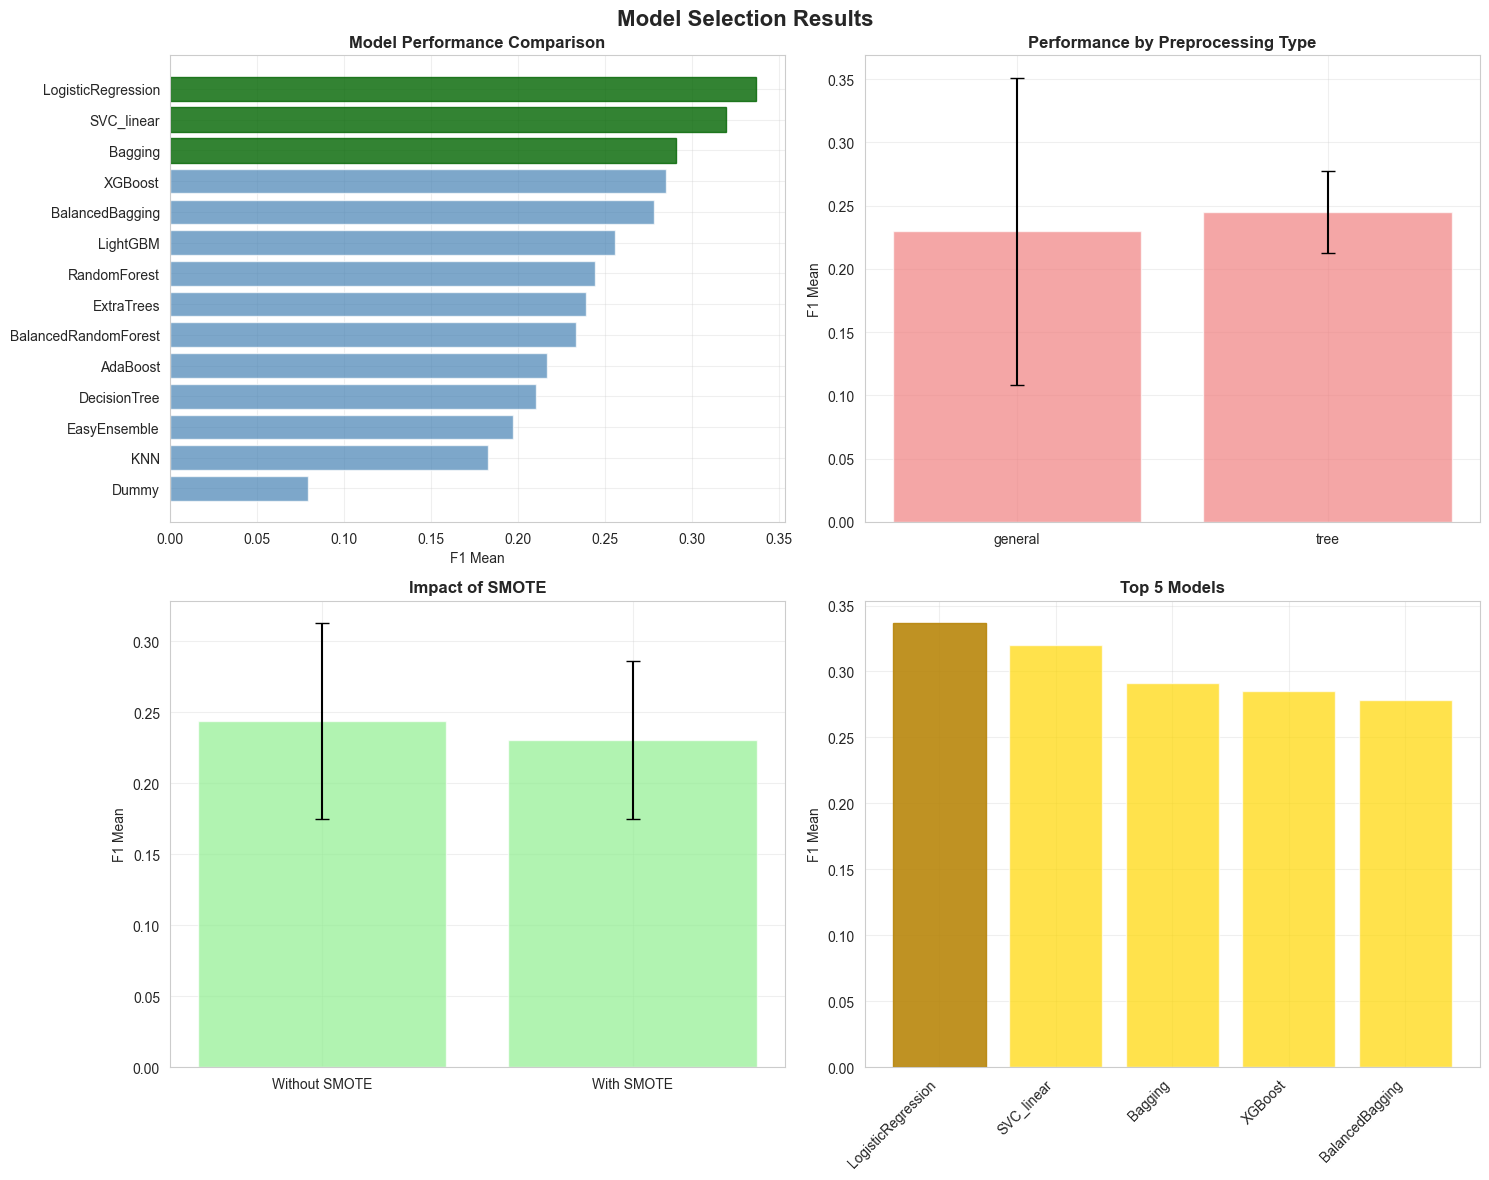

Visualization created successfully

Best model from selection: LogisticRegression with f1_mean: 0.3368
   Preprocessing type: general
   Uses SMOTE: False

Final Result: LogisticRegression selected as best model


In [12]:
# Display results with proper error handling
if not model_results_df.empty:
    try:
        # Sort and display results
        if PRIMARY_METRIC_MODEL_SELECTION in model_results_df.columns:
            sorted_df = model_results_df.sort_values(by=PRIMARY_METRIC_MODEL_SELECTION, ascending=False)
            display(sorted_df)
        else:
            print(f"Warning: Primary metric '{PRIMARY_METRIC_MODEL_SELECTION}' not found in results")
            display(model_results_df)
    except Exception as e:
        print(f"Error displaying results: {e}")
        display(model_results_df.head())
else:
    print("No model results to display.")

# Analyze results with comprehensive validation
best_model_name = None
analysis_summary = {}

if not model_results_df.empty and PRIMARY_METRIC_MODEL_SELECTION in model_results_df.columns:
    # Filter out models with errors or NaN scores
    valid_model_results_df = model_results_df.dropna(subset=[PRIMARY_METRIC_MODEL_SELECTION])
    if 'error' in model_results_df.columns:
        valid_model_results_df = valid_model_results_df[valid_model_results_df['error'].isna()]
    
    if not valid_model_results_df.empty:
        try:
            analysis_summary = analyze_model_results(valid_model_results_df, primary_metric=PRIMARY_METRIC_MODEL_SELECTION)
            
            # Only create visualization if analysis succeeded
            if analysis_summary and 'error' not in analysis_summary:
                create_results_visualization(valid_model_results_df, analysis_summary, primary_metric=PRIMARY_METRIC_MODEL_SELECTION)

                # Extract best model information safely
                if 'best_model' in analysis_summary and analysis_summary['best_model']:
                    best_model_info = analysis_summary['best_model']
                    best_model_name = best_model_info['name']
                    print(f"\nBest model from selection: {best_model_name} with {PRIMARY_METRIC_MODEL_SELECTION}: {best_model_info['score']:.4f}")
                    
                    # Additional model details
                    print(f"   Preprocessing type: {best_model_info.get('preprocessing', 'unknown')}")
                    print(f"   Uses SMOTE: {best_model_info.get('uses_smote', 'unknown')}")
                else:
                    print("\nCould not extract best model information from analysis")
            else:
                print(f"\nAnalysis failed: {analysis_summary.get('error', 'Unknown error')}")
                
        except Exception as e:
            print(f"\nError during analysis: {e}")
            analysis_summary = {'error': str(e)}
    else:
        print(f"\nNo valid models with primary metric '{PRIMARY_METRIC_MODEL_SELECTION}' found after filtering")
        print("This could be due to:")
        print("  - All models failed during cross-validation")
        print("  - Primary metric not calculated properly")
        print("  - Data loading or preprocessing issues")
        
elif not model_results_df.empty:
    print(f"\nPrimary metric '{PRIMARY_METRIC_MODEL_SELECTION}' not found in results columns")
    print(f"Available columns: {list(model_results_df.columns)}")
else:
    print("\nModel selection produced no results")
    print("This indicates a fundamental issue with:")
    print("  - Data loading")
    print("  - Model configuration") 
    print("  - Cross-validation setup")

# Final status summary
if best_model_name:
    print(f"\nFinal Result: {best_model_name} selected as best model")
else:
    print(f"\nNo best model could be determined")
    print("Review the errors above and check:")
    print("  - Data preprocessing artifacts")
    print("  - Model configurations")
    print("  - Cross-validation setup")

## Appendix — Feature Selection Benchmark

 

This appendix evaluates multiple feature selection strategies to identify an optimal approach. We first run quick, model-agnostic diagnostics, then benchmark representative filter, embedded, and wrapper methods across ALL CV folds.

 

Goals
- All-fold benchmark across methods (filter, embedded, wrapper) with a consistent downstream classifier.
- Aggregation identical to the rest of the notebook: compute unweighted mean and std across folds for each metric (e.g., `f1_mean`, `f1_std`, ...).
- Save results to:
  - `JupyterOutputs/Classification (Modeling)/feature_selection_benchmark_all_folds.csv`

 

Assumptions
- We reuse the preprocessing from earlier cells. If the general preprocessor isn't available, we fall back to the tree preprocessor.
- We reuse engineered labels from `precomputed_targets` and iterate all folds available in that structure.
- No resampling is applied; the goal is to isolate the impact of feature selection.

In [13]:
# Appendix — All-Folds Feature Selection Benchmark
import time
import json
import os
import pickle
import numpy as np
import pandas as pd
from collections import OrderedDict, defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, f_classif, mutual_info_classif, SelectFromModel, RFE
from sklearn.metrics import (
    f1_score, precision_score, recall_score, matthews_corrcoef,
    roc_auc_score, average_precision_score, accuracy_score, log_loss
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Fast-path: load cached aggregated results if available
all_folds_csv = os.path.join(modeling_results_dir, 'feature_selection_benchmark_all_folds.csv')
if os.path.exists(all_folds_csv):
    try:
        agg_sorted = pd.read_csv(all_folds_csv)
        print(f"Found cached Feature Selection benchmark. Reusing: {all_folds_csv}")
        print(f"Rows: {len(agg_sorted)}")
        display(agg_sorted)
    except Exception as e:
        print(f"Failed to load cached benchmark ({e}). Will recompute.")

if not os.path.exists(all_folds_csv):
    print("\n=== Running Feature Selection Benchmark Across All Folds ===")
    # Helper to get probability or decision scores
    def _get_scores(est, X):
        if hasattr(est, 'predict_proba'):
            return est.predict_proba(X)[:, 1]
        if hasattr(est, 'decision_function'):
            return est.decision_function(X)
        return None

    # Validate precomputed targets
    if 'precomputed_targets' not in globals() or precomputed_targets is None:
        with open(os.path.join(modeling_results_dir, 'precomputed_targets.pkl'), 'rb') as fh:
            precomputed_targets = pickle.load(fh)

    # Choose preprocessor (prefer general, else tree)
    pre_ct = preprocessor_general_ct if 'preprocessor_general_ct' in globals() and preprocessor_general_ct is not None else (
        preprocessor_trees_ct if 'preprocessor_trees_ct' in globals() else None
    )
    if pre_ct is None:
        raise RuntimeError("No available preprocessor for benchmark.")

    # Whether to add a scaler after selection (when using tree preprocessor + LR downstream)
    add_scaler = (pre_ct is preprocessor_trees_ct)

    # Utility to extract selected feature names after preprocessing
    from numpy import ndarray

    def _get_selected_feature_names(fitted_pipe: Pipeline, X_sample):
        # Try to get names from preprocessor
        try:
            if hasattr(fitted_pipe.named_steps['preprocessor'], 'get_feature_names_out'):
                all_names = np.array(fitted_pipe.named_steps['preprocessor'].get_feature_names_out())
            else:
                n_feats = fitted_pipe.named_steps['preprocessor'].transform(X_sample).shape[1]
                all_names = np.array([f'f{i}' for i in range(n_feats)])
        except Exception:
            # Fallback: anonymous names
            try:
                n_feats = fitted_pipe.named_steps['preprocessor'].transform(X_sample).shape[1]
                all_names = np.array([f'f{i}' for i in range(n_feats)])
            except Exception:
                return []

        sel = fitted_pipe.named_steps.get('selector', None)
        if sel is None:
            return list(all_names)
        try:
            if hasattr(sel, 'get_support'):
                mask = sel.get_support(indices=False)
                if isinstance(mask, (list, np.ndarray)) and len(mask) == len(all_names):
                    return list(all_names[mask])
        except Exception:
            pass
        return []

    # Build candidates: baseline, filters, embedded, wrapper
    percentiles = [10, 25, 50, 75]

    candidates = OrderedDict()
    candidates['Baseline-NoSelection'] = None
    for p in percentiles:
        candidates[f'Filter-SelectPercentile(f_classif,{p}%)'] = SelectPercentile(score_func=f_classif, percentile=p)
        candidates[f'Filter-SelectPercentile(mutual_info,{p}%)'] = SelectPercentile(score_func=lambda X, y: mutual_info_classif(X, y, random_state=42), percentile=p)
    candidates['Embedded-SelectFromModel(LogReg-L1)'] = SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=42))
    candidates['Embedded-SelectFromModel(RandomForest@median)'] = SelectFromModel(estimator=RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced'), threshold='median')

    from imblearn.pipeline import Pipeline as ImbPipeline
    fold0 = precomputed_targets[0]
    X_tr0 = X_train_sorted.iloc[fold0['train_idx']]
    y_tr0 = fold0['y_train_engineered']
    _tmp = ImbPipeline([('preprocessor', pre_ct)])
    X_tr_pre = _tmp.fit_transform(X_tr0, y_tr0)
    post_p_dim = X_tr_pre.shape[1]
    print(f"Post-preprocessor dimensionality (fold0): {post_p_dim}")
    assert post_p_dim > 1, "Preprocessor produced <=1 feature – check pipeline."
    wrapper_select_n = max(1, int(round(post_p_dim * 0.5)))

    candidates['Wrapper-RFE(LogReg,50%)'] = RFE(
        estimator=LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced', solver='liblinear'),
        n_features_to_select=wrapper_select_n,
        step=0.2
    )

    base_clf = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced', solver='liblinear')

    per_fold_rows = []
    n_folds = len(precomputed_targets)
    print(f"Benchmarking {len(candidates)} FS strategies across {n_folds} folds…")

    for fold_idx in range(n_folds):
        fold_dict = precomputed_targets[fold_idx]
        train_idx = fold_dict['train_idx']
        val_idx = fold_dict['val_idx']
        y_tr = fold_dict['y_train_engineered']
        y_val = fold_dict['y_val_engineered']

        X_tr = X_train_sorted.iloc[train_idx]
        X_val = X_train_sorted.iloc[val_idx]

        for name, selector in candidates.items():
            start = time.time()
            try:
                steps = [('preprocessor', pre_ct)]
                if selector is not None:
                    steps.append(('selector', selector))
                if add_scaler:
                    steps.append(('scaler', StandardScaler(with_mean=False)))
                steps.append(('clf', base_clf))
                pipe = Pipeline(steps)

                pipe.fit(X_tr, y_tr)
                y_pred = pipe.predict(X_val)
                y_score = _get_scores(pipe, X_val)

                row = {
                    'fold': fold_idx,
                    'method': name,
                    'features_selected': None,
                    'fit_seconds': time.time() - start,
                    'f1': f1_score(y_val, y_pred, zero_division=0),
                    'precision': precision_score(y_val, y_pred, zero_division=0),
                    'recall': recall_score(y_val, y_pred, zero_division=0),
                    'accuracy': accuracy_score(y_val, y_pred),
                    'mcc': matthews_corrcoef(y_val, y_pred)
                }
                if y_score is not None:
                    row['roc_auc'] = roc_auc_score(y_val, y_score)
                    row['pr_auc'] = average_precision_score(y_val, y_score)
                    try:
                        row['neg_log_loss'] = -log_loss(y_val, y_score, labels=[0, 1])
                    except Exception:
                        row['neg_log_loss'] = np.nan
                else:
                    row.update({'roc_auc': np.nan, 'pr_auc': np.nan, 'neg_log_loss': np.nan})

                try:
                    if selector is None:
                        feats = _get_selected_feature_names(pipe, X_tr)
                        row['features_selected'] = len(feats) if feats else post_p_dim
                    else:
                        sel_step = pipe.named_steps['selector']
                        feats = _get_selected_feature_names(pipe, X_tr)
                        if feats:
                            row['features_selected'] = len(feats)
                        elif hasattr(sel_step, 'get_support'):
                            supp = sel_step.get_support(indices=False)
                            row['features_selected'] = int(np.sum(supp))
                except Exception:
                    pass

                per_fold_rows.append(row)
                print(f"fold {fold_idx} | {name} -> F1: {row['f1']:.4f}, PR AUC: {row['pr_auc'] if not np.isnan(row['pr_auc']) else 'NA'}, selected: {row['features_selected']}")
            except Exception as e:
                per_fold_rows.append({'fold': fold_idx, 'method': name, 'error': str(e)})
                print(f"ERROR fold {fold_idx} | {name}: {e}")

    per_fold_df = pd.DataFrame(per_fold_rows)

    metric_cols = ['f1', 'precision', 'recall', 'accuracy', 'mcc', 'roc_auc', 'pr_auc', 'neg_log_loss', 'fit_seconds', 'features_selected']

    agg_rows = []
    for name in candidates.keys():
        # Build a proper mask: keep rows without errors; if no 'error' column, keep all
        if 'error' in per_fold_df.columns:
            ok_mask = per_fold_df['error'].isna()
        else:
            ok_mask = pd.Series(True, index=per_fold_df.index)

        sub = per_fold_df[(per_fold_df['method'] == name) & (ok_mask)]
        row = {'method': name}
        for m in metric_cols:
            if m in sub.columns and len(sub):
                vals = pd.to_numeric(sub[m], errors='coerce')
                row[f'{m}_mean'] = float(np.nanmean(vals)) if len(vals) else np.nan
                row[f'{m}_std']  = float(np.nanstd(vals))  if len(vals) else np.nan
            else:
                row[f'{m}_mean'] = np.nan
                row[f'{m}_std'] = np.nan
        row['n_folds'] = int(sub['fold'].nunique()) if 'fold' in sub.columns and len(sub) else 0
        agg_rows.append(row)

    agg_df = pd.DataFrame(agg_rows)

    sort_primary = PRIMARY_METRIC_MODEL_SELECTION if 'PRIMARY_METRIC_MODEL_SELECTION' in globals() else 'f1_mean'
    sort_cols = [sort_primary, 'pr_auc_mean']
    agg_sorted = agg_df.sort_values(sort_cols, ascending=[False, False], na_position='last')

    print("\nAggregated across folds (mean/std like main CV):")
    display(agg_sorted)

    agg_sorted.to_csv(all_folds_csv, index=False)
    print(f"Saved aggregated results to: {all_folds_csv}")


Found cached Feature Selection benchmark. Reusing: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Modeling)\feature_selection_benchmark_all_folds.csv
Rows: 12


,method,f1_mean,f1_std,precision_mean,precision_std,recall_mean,recall_std,accuracy_mean,accuracy_std,mcc_mean,...,roc_auc_std,pr_auc_mean,pr_auc_std,neg_log_loss_mean,neg_log_loss_std,fit_seconds_mean,fit_seconds_std,features_selected_mean,features_selected_std,n_folds
0,Embedded-SelectFromModel(RandomForest@median),0.336789,0.035335,0.218864,0.030188,0.743199,0.024100,0.867223,0.020218,0.354822,...,0.009667,0.340302,0.024634,-0.292498,0.021753,24.550712,2.679345,28.0,0.000000,5
1,"Filter-SelectPercentile(f_classif,75%)",0.319508,0.029514,0.202848,0.023534,0.761019,0.031334,0.852493,0.025641,0.342147,...,0.010462,0.330498,0.026011,-0.309264,0.031130,4.521336,0.321056,41.6,0.489898,5
2,"Filter-SelectPercentile(mutual_info,50%)",0.318985,0.033848,0.202174,0.027168,0.768466,0.030079,0.852476,0.009166,0.343414,...,0.007028,0.332549,0.027335,-0.309765,0.011052,66.380577,2.267108,27.6,0.489898,5
3,"Filter-SelectPercentile(mutual_info,75%)",0.314422,0.037251,0.198348,0.029332,0.770677,0.016175,0.848102,0.016481,0.339371,...,0.010634,0.328214,0.029390,-0.313611,0.018266,70.415523,7.114362,41.6,0.489898,5
4,Embedded-SelectFromModel(LogReg-L1),0.312327,0.031686,0.196379,0.024508,0.771117,0.017456,0.846702,0.017093,0.337524,...,0.009999,0.328165,0.026622,-0.315535,0.020288,42.907044,6.883095,51.4,1.019804,5
5,Baseline-NoSelection,0.308222,0.034355,0.193050,0.026503,0.774721,0.016686,0.842884,0.017414,0.334310,...,0.010509,0.326262,0.027790,-0.319807,0.020073,4.691178,0.968289,55.6,0.489898,5
6,"Wrapper-RFE(LogReg,50%)",0.308186,0.034728,0.193238,0.027138,0.772799,0.022151,0.843738,0.011559,0.334026,...,0.008979,0.321281,0.024768,-0.318404,0.012698,10.965352,0.329514,28.0,0.000000,5
7,"Filter-SelectPercentile(f_classif,50%)",0.266037,0.069877,0.164157,0.057601,0.824271,0.080052,0.779631,0.067960,0.299675,...,0.011879,0.313168,0.027001,-0.407270,0.092096,3.048254,0.172264,27.6,0.489898,5
8,"Filter-SelectPercentile(f_classif,25%)",0.168736,0.018427,0.092985,0.011104,0.922375,0.010412,0.591297,0.007324,0.207396,...,0.006523,0.179962,0.016909,-0.742232,0.010185,2.409188,0.172233,14.0,0.000000,5
9,"Filter-SelectPercentile(mutual_info,25%)",0.168044,0.017792,0.092614,0.010748,0.917606,0.016620,0.591569,0.008650,0.205594,...,0.007060,0.170116,0.013888,-0.734280,0.014735,64.715269,1.631338,14.0,0.000000,5
